In [1]:

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error



import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping


# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
file_path = '/kaggle/input/niftybees-historical/niftybees_historical.csv'

df = pd.read_csv(file_path,parse_dates=['timestamp'])

In [3]:
df = df.drop('_id', axis=1)

df['timestamp'] = pd.to_datetime(df['timestamp'])

df = df.sort_values('timestamp')



# Extract the date component and create a new 'date' column

df['date'] = df['timestamp'].dt.date



# Drop the original 'timestamp' column

df = df.drop('timestamp', axis=1)



df['date'] = pd.to_datetime(df['date'])

df.set_index('date', inplace=True)


In [4]:
df.head()

,close,high,low,open,pe_ratio,volume
date,,,,,,
2014-05-26,73.890999,75.051002,72.870003,74.398003,30.520233,1167030
2014-05-27,73.138000,73.900002,73.000000,73.900002,30.520233,807380
2014-05-28,73.317001,73.744003,73.100998,73.400002,30.520233,464650
2014-05-29,72.962997,73.523003,72.820000,73.349998,30.520233,3796890
2014-05-30,72.375000,73.199997,72.209999,73.099998,30.520233,2466710


In [5]:
df.tail()

,close,high,low,open,pe_ratio,volume
date,,,,,,
2024-10-04,280.149994,284.510010,279.350006,283.190002,30.520233,11510706
2024-10-07,278.010010,281.579987,276.079987,281.450012,30.520233,10673683
2024-10-08,279.399994,279.850006,276.660004,278.989990,30.520233,6795305
2024-10-09,278.720001,281.989990,278.230011,281.989990,30.520233,5937406
2024-10-10,279.299988,280.989990,279.000000,280.989990,30.520233,3029027


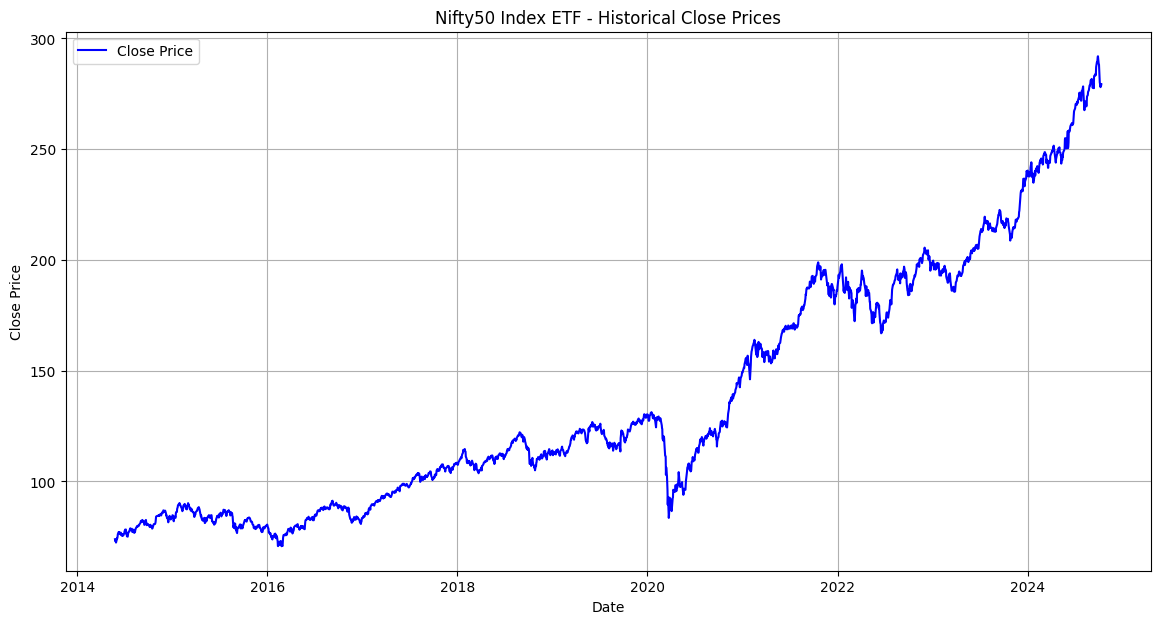

In [6]:
# Plot historical close prices

plt.figure(figsize=(14, 7))

plt.plot(df.index, df['close'], label='Close Price', color='blue')

plt.title('Nifty50 Index ETF - Historical Close Prices')

plt.xlabel('Date')

plt.ylabel('Close Price')

plt.legend()

plt.grid(True)

plt.show()


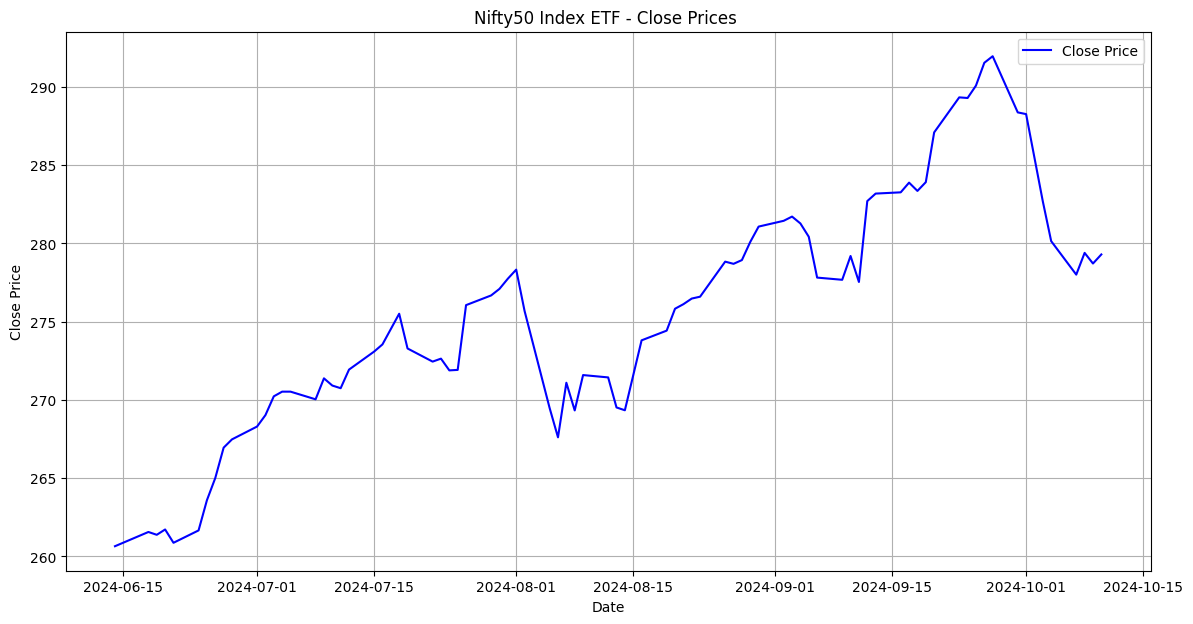

In [7]:
# Define the  period

start_date = '2024-06-14'

end_date = '2024-10-11'



# Slice the DataFrame

df_anomaly = df.loc[start_date:end_date]



# Plot the close prices during the anomaly period

plt.figure(figsize=(14, 7))

plt.plot(df_anomaly.index, df_anomaly['close'], label='Close Price', color='blue')

plt.title('Nifty50 Index ETF - Close Prices ')

plt.xlabel('Date')

plt.ylabel('Close Price')

plt.legend()

plt.grid(True)

plt.show()


**DESCRIPTIVE STATISTICS**

In [8]:
df.describe()

,close,high,low,open,pe_ratio,volume
count,2559.000000,2559.000000,2559.000000,2559.000000,2559.000000,2.559000e+03
mean,137.993982,139.989119,136.505882,139.047145,30.520233,1.618686e+06
std,55.319942,56.317955,54.873701,56.278363,0.000000,1.983132e+06
min,70.732002,71.500000,12.905000,12.920000,30.520233,0.000000e+00
25%,89.202892,89.850002,88.674999,89.380501,30.520233,3.184210e+05
50%,117.870003,118.800003,116.425003,117.900002,30.520233,8.587700e+05
75%,186.310005,190.000000,184.010002,188.470001,30.520233,2.334988e+06
max,291.970001,293.989990,291.350006,291.950012,30.520233,3.249676e+07


# **TECHNICAL ANALYSIS - SIMPLE AND EXPONENTIAL MOVING AVERAGES**

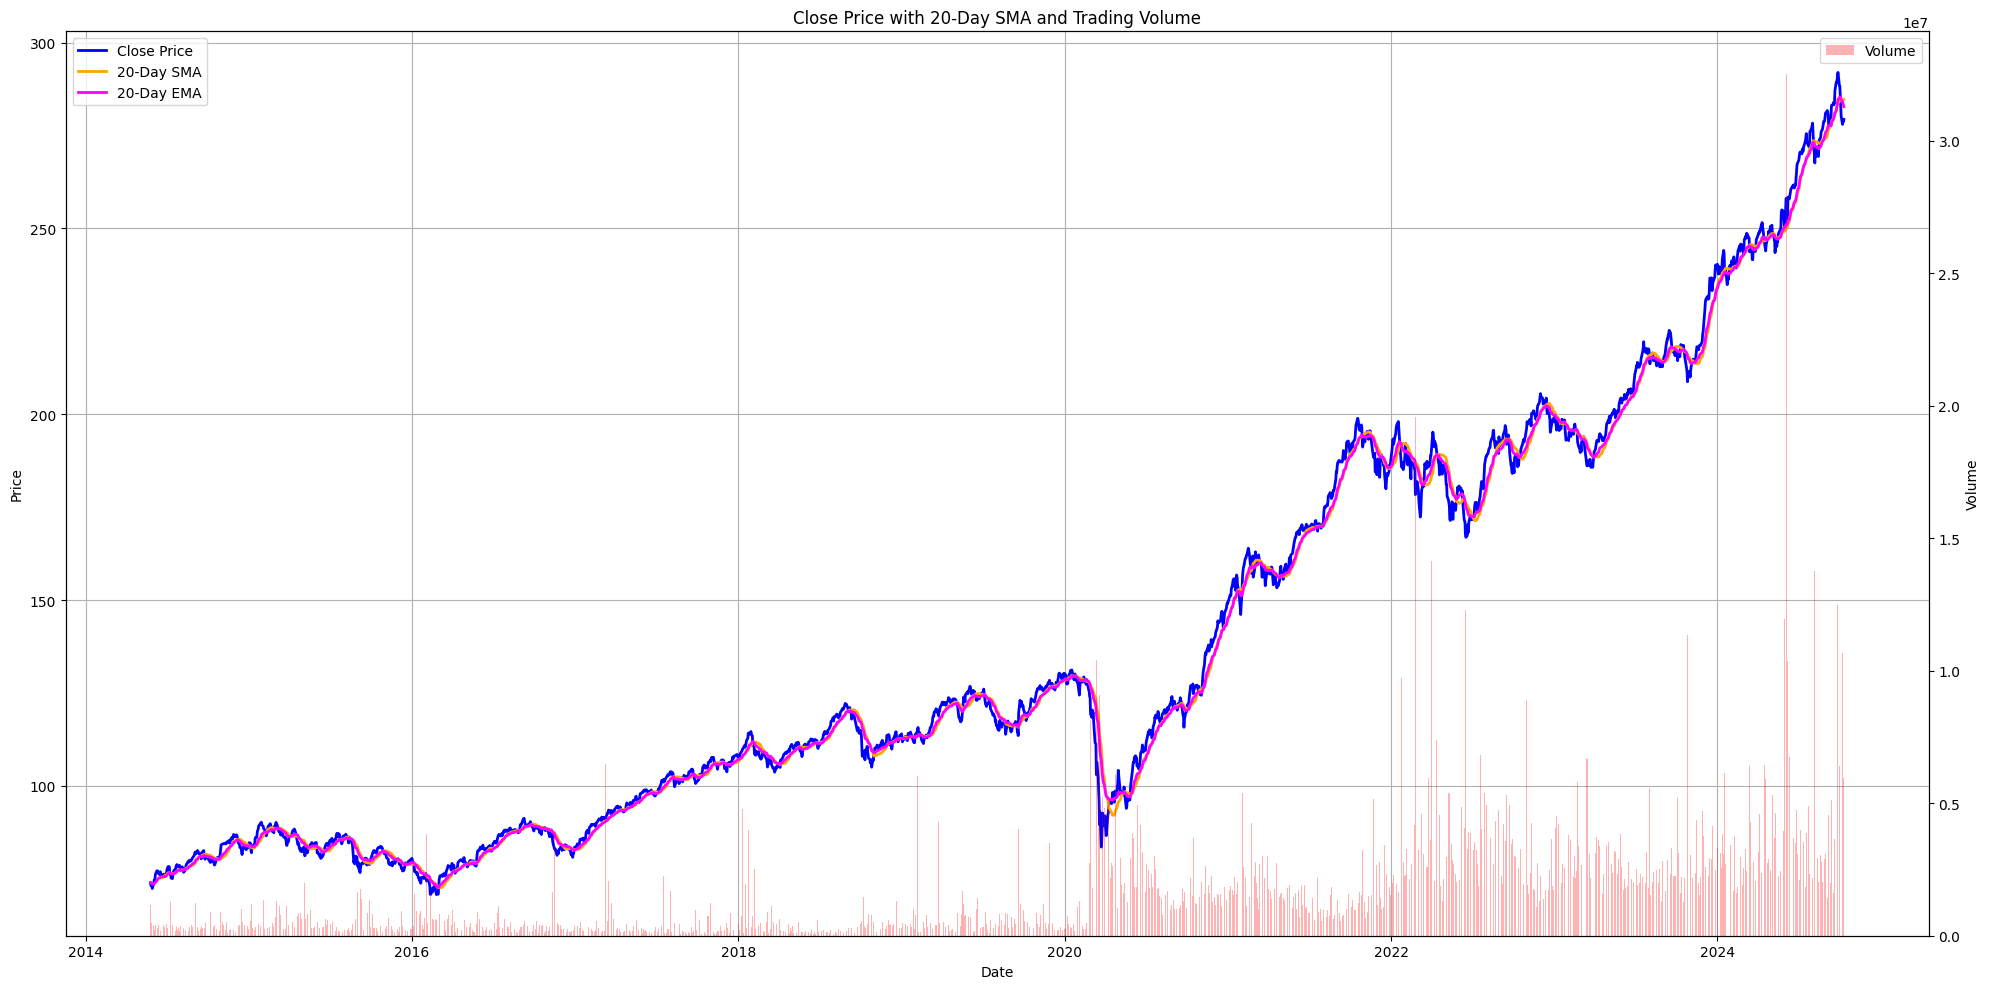

In [9]:


# Calculating the Simple and Exponential Moving Averages

df['SMA_20'] = df['close'].rolling(window=20).mean()

df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()



# Set up the figure

fig, ax1 = plt.subplots(figsize=(20, 10))



# First plot: Close price with SMA and EMA (on the primary y-axis)

ax1.plot(df.index, df['close'], label='Close Price', color='blue', linewidth=2)

ax1.plot(df.index, df['SMA_20'], label='20-Day SMA', color='orange', linewidth=2)

ax1.plot(df.index, df['EMA_20'], label='20-Day EMA', color='magenta', linewidth=2)



ax1.set_xlabel('Date')

ax1.set_ylabel('Price')

ax1.set_title('Close Price with 20-Day SMA and Trading Volume')



# Adding a legend for the price lines

ax1.legend(loc='upper left')



# Enable grid for the first plot

ax1.grid(True)



# Create a secondary y-axis for the volume bars

ax2 = ax1.twinx()



# Plot the volume bars on the secondary y-axis

ax2.bar(df.index, df['volume'], label='Volume', color='red', alpha=0.3, width=0.8)



# Setting labels and grid for the secondary axis

ax2.set_ylabel('Volume')

ax2.legend(loc='upper right')



# Show the combined plot

plt.tight_layout()

plt.show()


## BULLISH AND BEARISH TREND

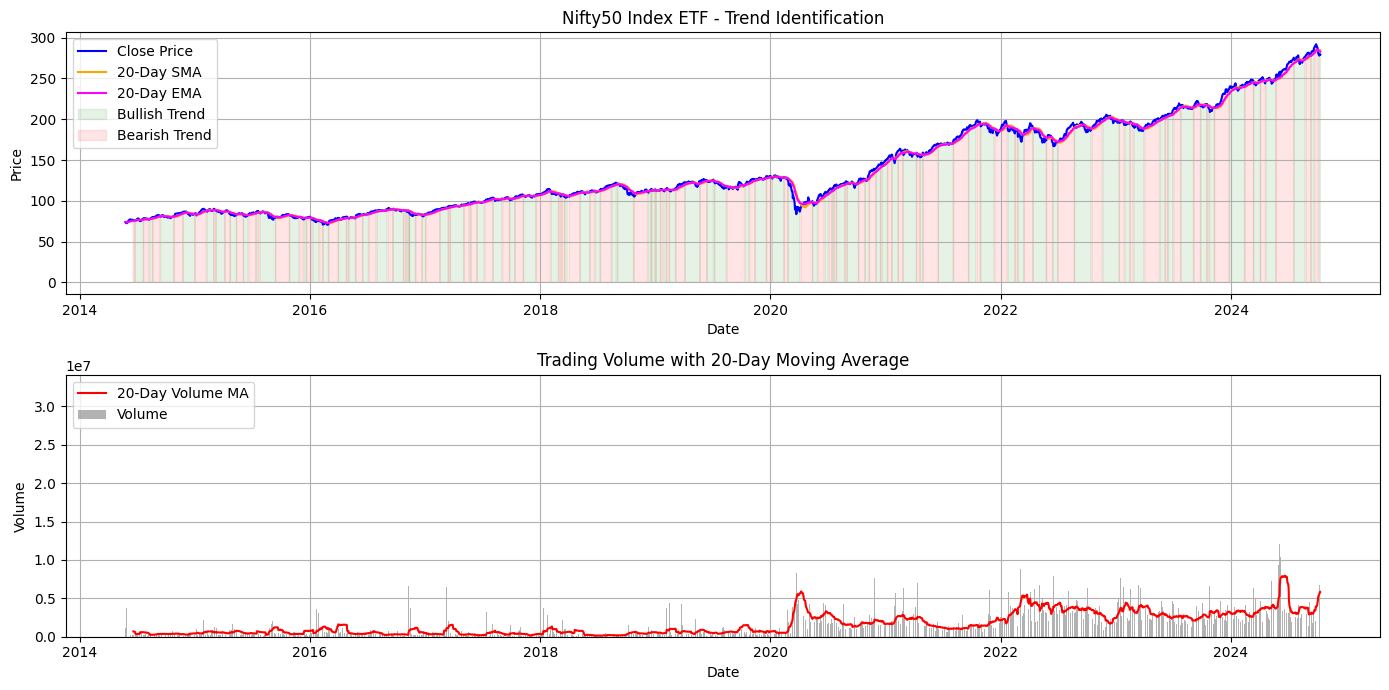

In [10]:
# Ensure Volume_MA20 is computed
df['Volume_MA20'] = df['volume'].rolling(window=20).mean()

# Identify crossover points
df['Signal'] = 0
df.loc[df['SMA_20'] > df['EMA_20'], 'Signal'] = 1  # Bullish
df.loc[df['SMA_20'] < df['EMA_20'], 'Signal'] = -1  # Bearish

# Plot with trend shading
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(df.index, df['close'], label='Close Price', color='blue')
plt.plot(df.index, df['SMA_20'], label='20-Day SMA', color='orange')
plt.plot(df.index, df['EMA_20'], label='20-Day EMA', color='magenta')

# Shade regions based on trend
plt.fill_between(df.index, df['close'], where=(df['Signal'] == 1), color='green', alpha=0.1, label='Bullish Trend')
plt.fill_between(df.index, df['close'], where=(df['Signal'] == -1), color='red', alpha=0.1, label='Bearish Trend')

plt.title('Nifty50 Index ETF - Trend Identification')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)

# Plot Volume with Rolling Average
plt.subplot(2, 1, 2)
plt.bar(df.index, df['volume'], label='Volume', color='grey', alpha=0.6)
plt.plot(df.index, df['Volume_MA20'], label='20-Day Volume MA', color='red')

plt.title('Trading Volume with 20-Day Moving Average')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


Momentum analysis

# MOMENTUM ANALYSIS

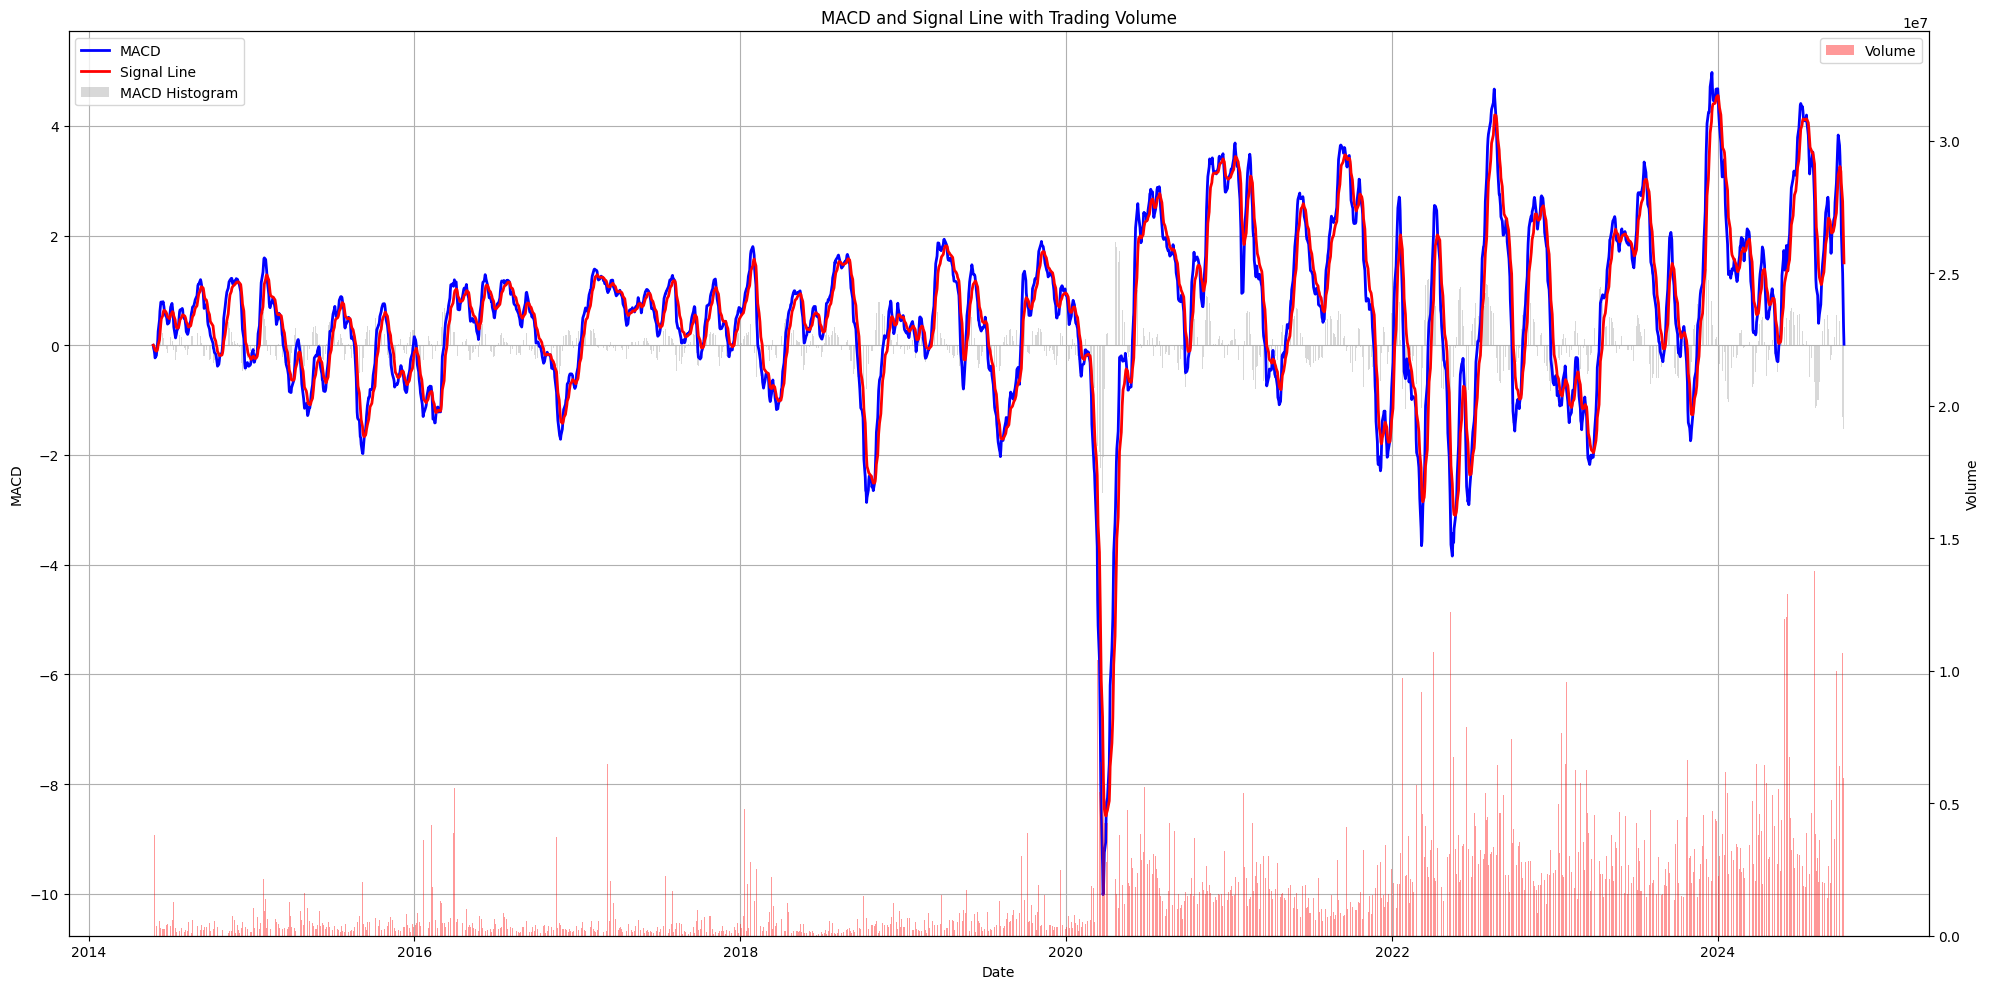

In [11]:




# Calculate MACD and Signal Line

df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()

df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

df['MACD'] = df['EMA_12'] - df['EMA_26']

df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()



# Set up the figure and axes

fig, ax1 = plt.subplots(figsize=(20, 10))



# First plot: MACD, Signal Line, and Histogram on the primary y-axis

ax1.plot(df.index, df['MACD'], label='MACD', color='blue', linewidth=2)

ax1.plot(df.index, df['Signal_Line'], label='Signal Line', color='red', linewidth=2)

ax1.bar(df.index, df['MACD'] - df['Signal_Line'], label='MACD Histogram', color='grey', alpha=0.3, width=0.8)



ax1.set_xlabel('Date')

ax1.set_ylabel('MACD')

ax1.set_title('MACD and Signal Line with Trading Volume')



# Add a legend for MACD-related plots

ax1.legend(loc='upper left')



# Enable grid for MACD plot

ax1.grid(True)



# Secondary y-axis for the volume bars

ax2 = ax1.twinx()



# Plot the volume bars on the secondary y-axis

ax2.bar(df.index, df['volume'], label='Volume', color='red', alpha=0.4, width=0.8)



# Set labels for the secondary y-axis

ax2.set_ylabel('Volume')

ax2.legend(loc='upper right')



# Adjust the layout and show the plot

plt.tight_layout()

plt.show()


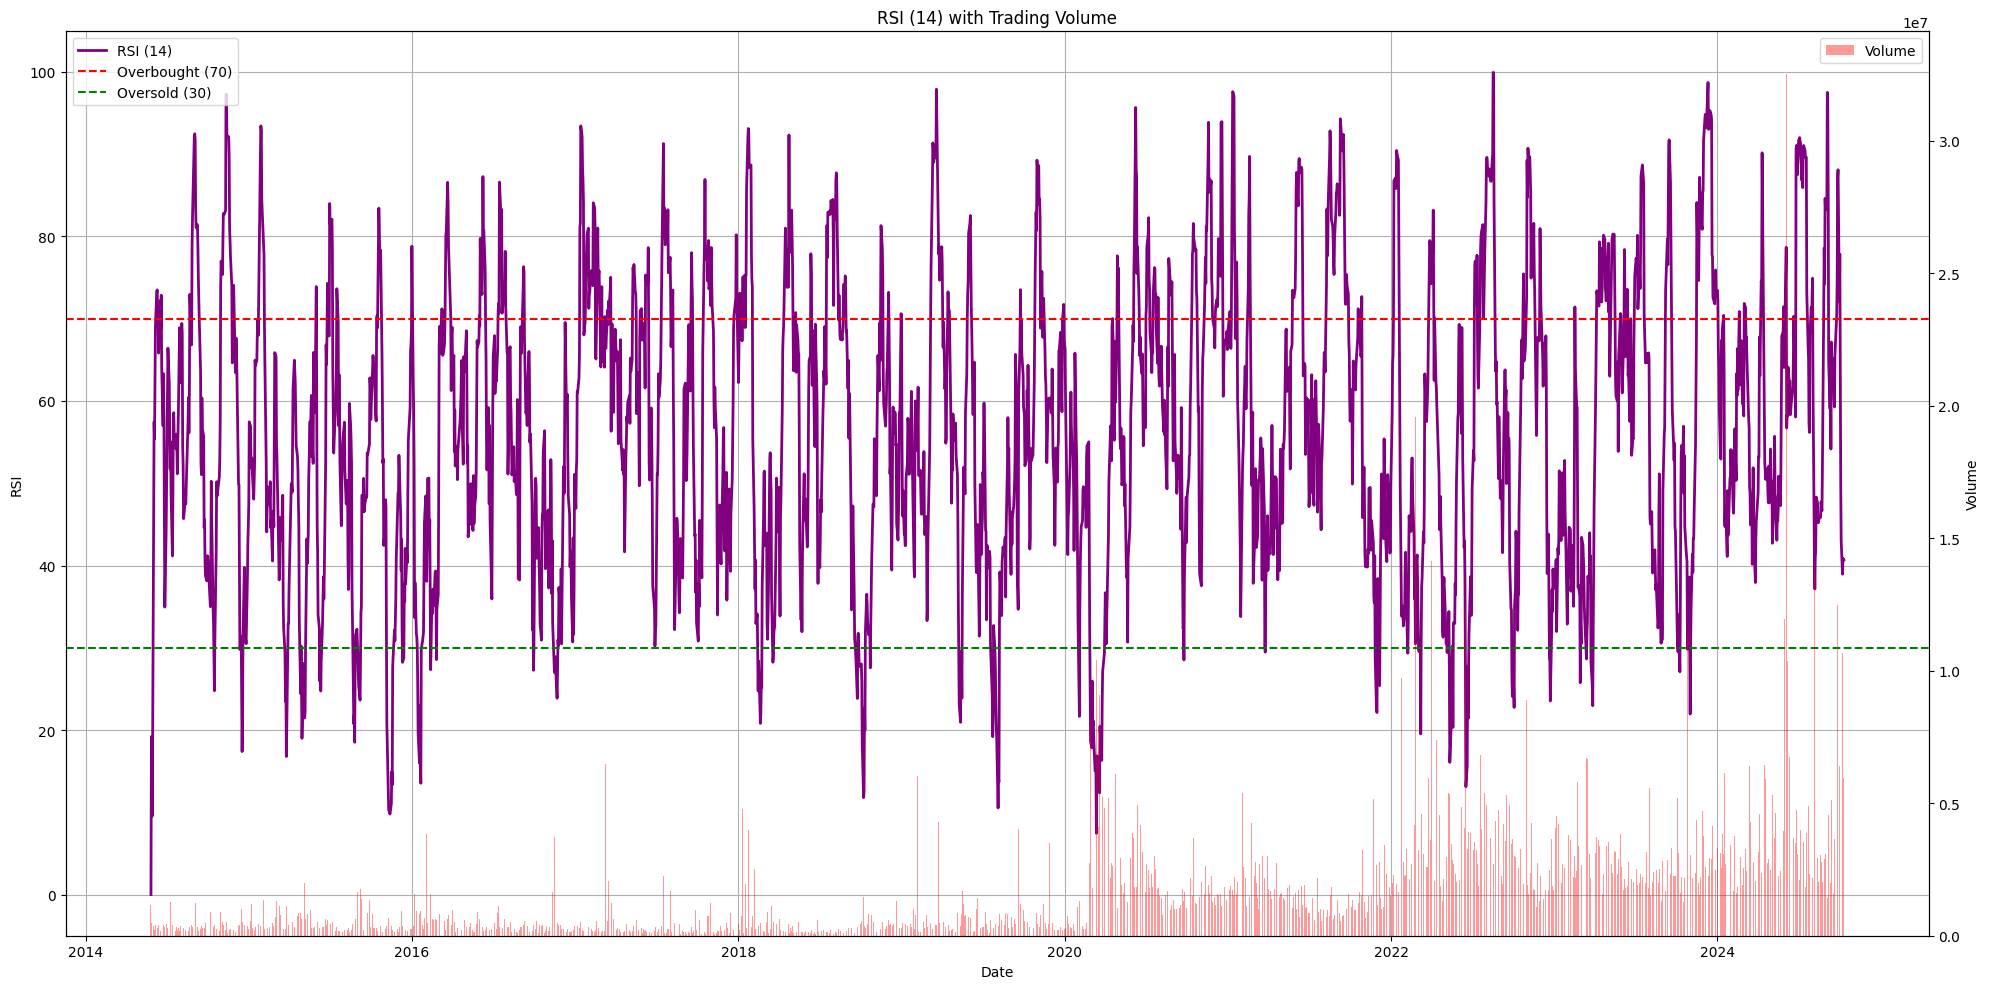

In [12]:


# RSI Calculation function

def calculate_rsi(series, period=14):

    delta = series.diff()

    gain = delta.clip(lower=0)

    loss = -1 * delta.clip(upper=0)

    avg_gain = gain.rolling(window=period, min_periods=1).mean()

    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))

    return rsi



# Calculate RSI and add it to the DataFrame

df['RSI_14'] = calculate_rsi(df['close'], 14)



# Set up the figure and axes

fig, ax1 = plt.subplots(figsize=(20, 10))



# First plot: RSI (on the primary y-axis)

ax1.plot(df.index, df['RSI_14'], label='RSI (14)', color='purple', linewidth=2)

ax1.axhline(70, color='red', linestyle='--', label='Overbought (70)')

ax1.axhline(30, color='green', linestyle='--', label='Oversold (30)')

ax1.set_xlabel('Date')

ax1.set_ylabel('RSI')

ax1.set_title('RSI (14) with Trading Volume')



# Add a legend for the RSI plot

ax1.legend(loc='upper left')



# Enable grid for the first plot

ax1.grid(True)



# Secondary y-axis for the volume bars

ax2 = ax1.twinx()



# Plot the volume bars on the secondary y-axis

ax2.bar(df.index, df['volume'], label='Volume', color='red', alpha=0.4, width=0.8)



# Set labels for the secondary y-axis

ax2.set_ylabel('Volume')

ax2.legend(loc='upper right')



# Adjust the layout and show the plot

plt.tight_layout()

plt.show()


# VOLUMETRIC ANALYSIS

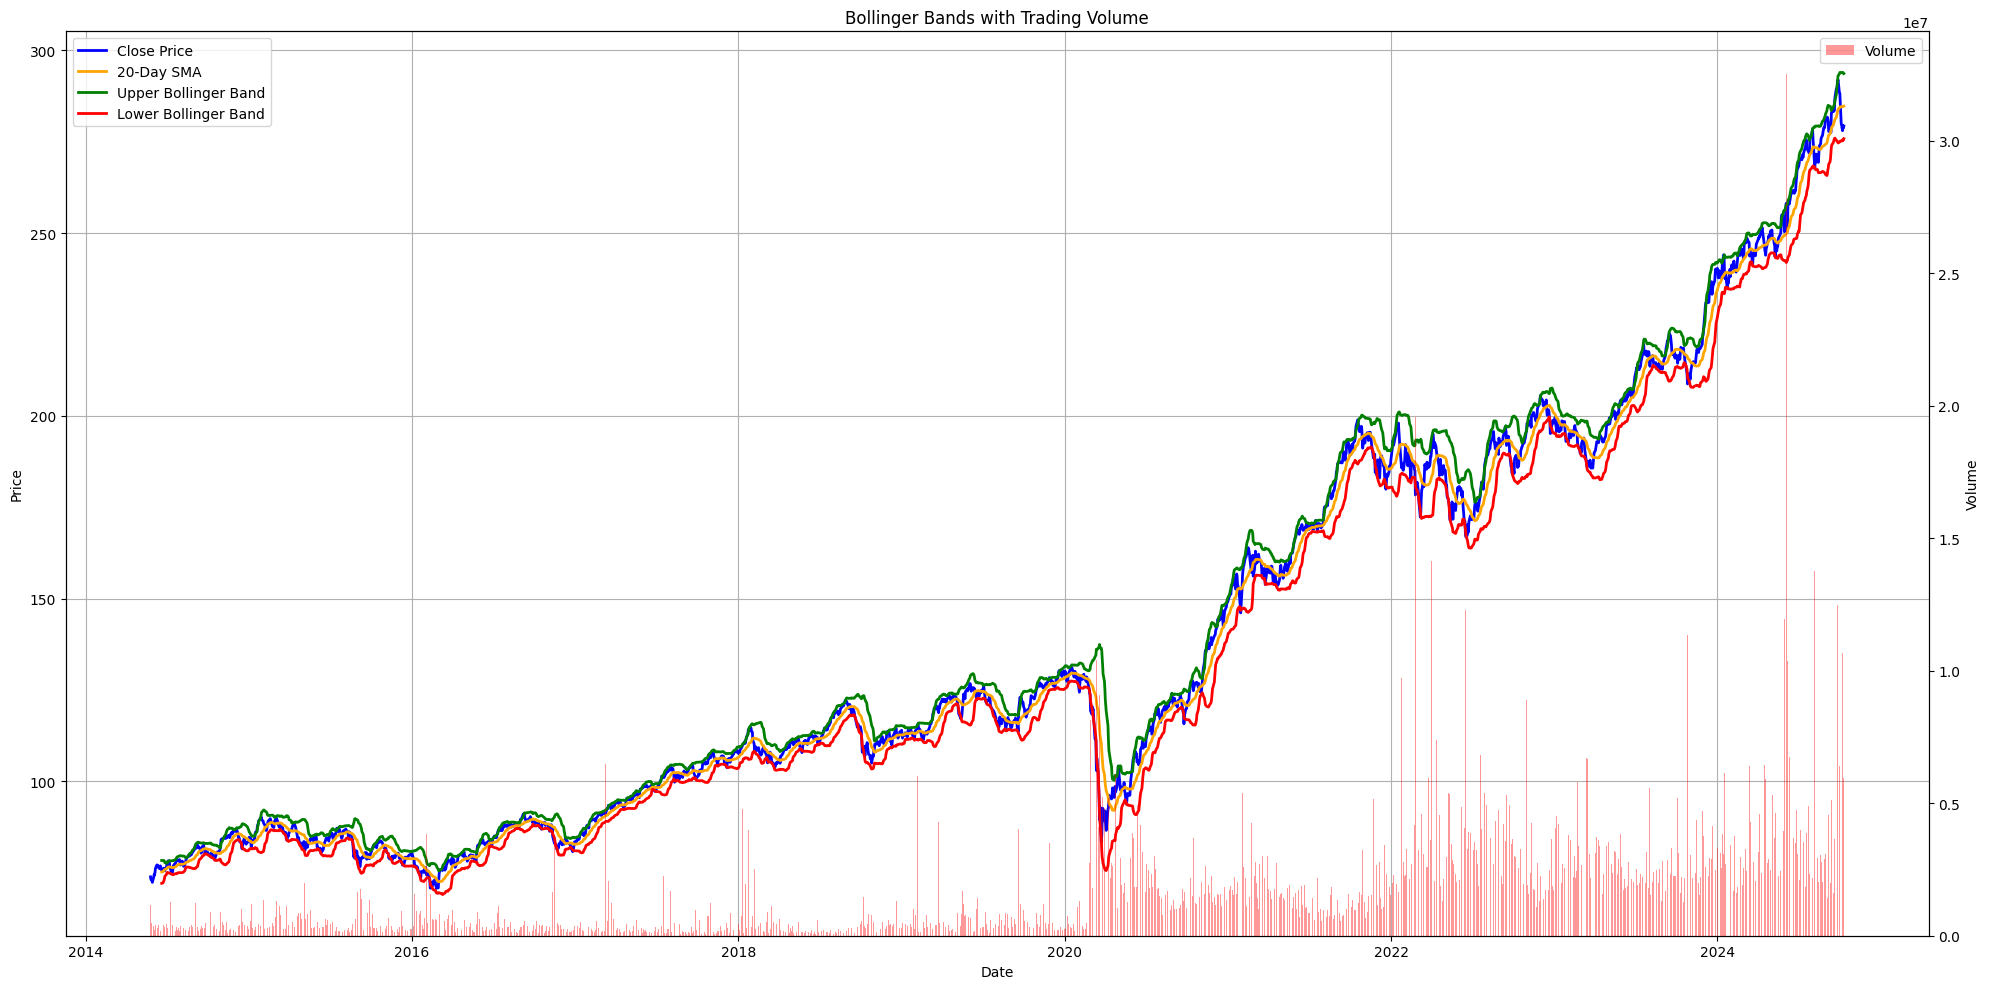

In [13]:


# Calculate Bollinger Bands (20-day)

df['BB_Middle'] = df['close'].rolling(window=20).mean()

df['BB_Std'] = df['close'].rolling(window=20).std()

df['BB_Upper'] = df['BB_Middle'] + (2 * df['BB_Std'])

df['BB_Lower'] = df['BB_Middle'] - (2 * df['BB_Std'])



# Set up the figure and axes

fig, ax1 = plt.subplots(figsize=(20, 10))



# First plot: Bollinger Bands and Close Price on the primary y-axis

ax1.plot(df.index, df['close'], label='Close Price', color='blue', linewidth=2)

ax1.plot(df.index, df['BB_Middle'], label='20-Day SMA', color='orange', linewidth=2)

ax1.plot(df.index, df['BB_Upper'], label='Upper Bollinger Band', color='green', linewidth=2)

ax1.plot(df.index, df['BB_Lower'], label='Lower Bollinger Band', color='red', linewidth=2)



ax1.set_xlabel('Date')

ax1.set_ylabel('Price')

ax1.set_title('Bollinger Bands with Trading Volume')



# Add a legend for the Bollinger Bands plot

ax1.legend(loc='upper left')



# Enable grid for the Bollinger Bands plot

ax1.grid(True)



# Secondary y-axis for the volume bars

ax2 = ax1.twinx()



# Plot the volume bars on the secondary y-axis

ax2.bar(df.index, df['volume'], label='Volume', color='red', alpha=0.4, width=0.8)



# Set labels for the secondary y-axis

ax2.set_ylabel('Volume')

ax2.legend(loc='upper right')



# Adjust the layout and show the plot

plt.tight_layout()

plt.show()




Volume based trend analysis

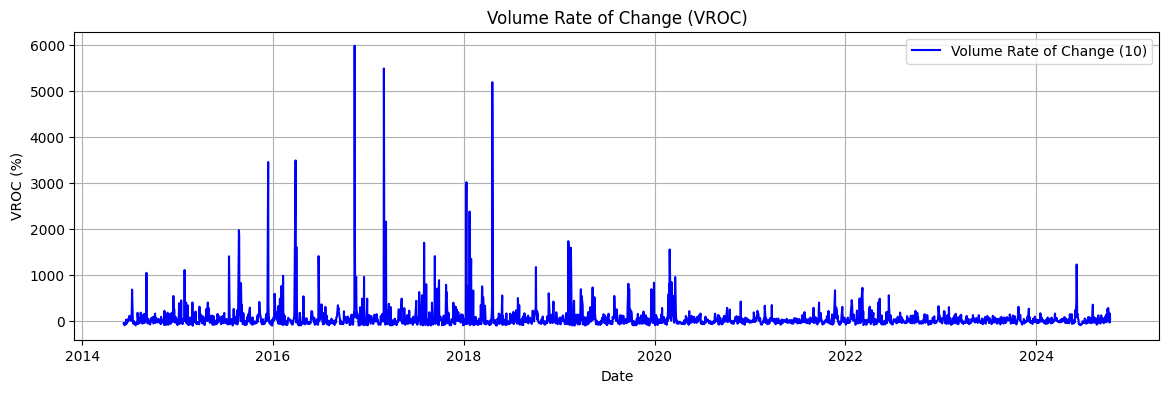

In [14]:
# Calculate Volume Rate of Change (VROC) over 10 periods

df['VROC_10'] = df['volume'].pct_change(periods=10) * 100  # Percentage change



# Plot VROC

plt.figure(figsize=(14, 4))

plt.plot(df.index, df['VROC_10'], label='Volume Rate of Change (10)', color='blue')

plt.title('Volume Rate of Change (VROC)')

plt.xlabel('Date')

plt.ylabel('VROC (%)')

plt.legend()

plt.grid(True)

plt.show()

# DATA PREPROCESSING----->MODEL TRAINING AND EVALUATION----->VISUALIZATION 

In [15]:

data = df[['close']].values  # Extract only the 'close' prices

In [16]:


# Define the split ratio
split_ratio = 0.8

# Compute the split index
split_index = int(len(data) * split_ratio)


# Split data into training and testing sets to avoid data leakage
train_data = data[:split_index]
test_data = data[split_index:]



# Initialize the scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit the scaler on the training data and transform it
train_data_scaled = scaler.fit_transform(train_data)

# Transform the test data using the scaler fitted on training data
test_data_scaled = scaler.transform(test_data)

In [17]:

# Function to create sequential data for 1-day forecast
def create_forecasting_sequences(data, look_back=1, forecast_horizon=1):
    X, y = [], []
    for i in range(len(data) - look_back - forecast_horizon):
        X.append(data[i:(i + look_back), :])  # Input: past 'look_back' days
        y.append(data[i + look_back + forecast_horizon - 1, 0])  
    return np.array(X), np.array(y)

# Define the look-back period and forecast horizon
look_back_1 = 21  #tommorrow forecast

# Create the sequences for 1-day forecast

X_train_1, y_train_1 = create_forecasting_sequences(train_data_scaled, look_back_1, forecast_horizon=1)
X_test_1, y_test_1 = create_forecasting_sequences(test_data_scaled, look_back_1, forecast_horizon=1)



In [18]:
# Check the shape of your training data


print(X_train_1.shape)
print(y_train_1.shape)

(2025, 21, 1)
(2025,)


In [19]:

print(X_test_1.shape)
print(y_test_1.shape)

(490, 21, 1)
(490,)


In [20]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM

def build_lstm_model(input_shape):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(units=64, return_sequences=True, input_shape=input_shape))
    
    # Second LSTM layer
    model.add(LSTM(units=64, return_sequences=False))

    
    model.add(Dense(units=32))
    
    
    # Output layer
    model.add(Dense(1, activation='linear'))  # Predicting stock price
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error',metrics = ["accuracy"])
    
    return model


In [21]:
input_shape_1day = (X_train_1.shape[1], X_train_1.shape[2])

# Build the model for forecast

models_1day = build_lstm_model(input_shape_1day)



# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)



# Train the 1-day forecast model
print("Training the 1-day forecast model")

history_1day = models_1day.fit(
     X_train_1, y_train_1,
    epochs=10, batch_size=10,
    validation_data=(X_test_1,y_test_1),
    verbose=1,
    callbacks=[early_stopping])

Training the 1-day forecast model
Epoch 1/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 6.2707e-04 - loss: 0.0227 - val_accuracy: 0.0000e+00 - val_loss: 0.0048
Epoch 2/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0011 - loss: 6.6697e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0109
Epoch 3/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0011 - loss: 6.3822e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0062
Epoch 4/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 2.0515e-04 - loss: 6.1069e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0035
Epoch 5/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 1.2246e-04 - loss: 5.7482e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0061
Epoch 6/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.0013 - loss: 4.8453e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.0022
Epoch 7/10
203/203 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 3.3693e-04 - loss: 3.4060e-04 - val_accuracy: 0.0000e+00 - val_loss: 0.

In [22]:

# Evaluate the '1-day' forecast model

print("Evaluating the 1-day forecast model")
evaluation_1day = models_1day.evaluate(X_test_1, y_test_1)
print(f"Test Loss for 1-day forecast: {evaluation_1day}")




Evaluating the 1-day forecast model
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0000e+00 - loss: 3.7358e-04
Test Loss for 1-day forecast: [0.00044541078386828303, 0.0]


In [23]:

# Predicting with the '1-day' forecast model

y_pred_1day_scaled = models_1day.predict(X_test_1)
y_pred_1day = scaler.inverse_transform(y_pred_1day_scaled)

# Inverse transform the true values

y_test_1day_scaled = y_test_1.reshape(-1, 1)
y_test_1day = scaler.inverse_transform(y_test_1day_scaled)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


In [24]:
from sklearn.metrics import r2_score
# Calculate metrics for 1-day forecast

mse_1day = mean_squared_error(y_test_1day, y_pred_1day)
rmse_1day = np.sqrt(mse_1day)
mae_1day = mean_absolute_error(y_test_1day, y_pred_1day)
r2_1day = r2_score(y_test_1day, y_pred_1day)

print("1-Day Forecast Evaluation:")
print(f"MSE: {mse_1day}")
print(f"RMSE: {rmse_1day}")
print(f"MAE: {mae_1day}")
print(f"R2 Score: {r2_1day}")

1-Day Forecast Evaluation:
MSE: 7.317920127238205
RMSE: 2.705165452839845
MAE: 2.1723910883884714
R2 Score: 0.9912886918725832


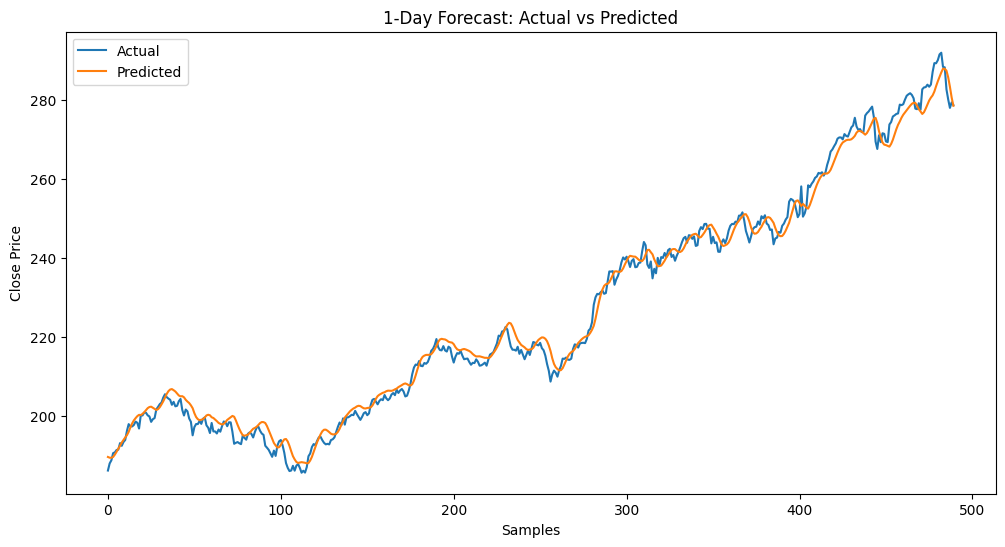

In [25]:


# For 1-day forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_1day, label='Actual')
plt.plot(y_pred_1day, label='Predicted')
plt.title('1-Day Forecast: Actual vs Predicted')
plt.xlabel('Samples')
plt.ylabel('Close Price')
plt.legend()
plt.show()



In [26]:
# Save the model 

models_1day.export('saved_model1day/')



Saved artifact at 'saved_model1day/'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 21, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134362710411568: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362710414208: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362710413856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362710419312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362710423536: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362710422832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362710420016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362705052592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362705055760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134362705056288: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [27]:
models_1day.save('saved_model1day.h5')

In [28]:
#import joblib

#joblib.dump(scaler, 'scaler.pkl')

In [29]:
#download the model from the working directory
import zipfile
import os
from IPython.display import FileLink

def zip_dir(directory = os.curdir, file_name = 'directory.zip'):
    os.chdir(directory)
    zip_ref = zipfile.ZipFile(file_name, mode='w')
    for folder, _, files in os.walk(directory):
        for file in files:
            if file_name in file:
                pass
            else:
                zip_ref.write(os.path.join(folder, file))

    return FileLink(file_name)

In [30]:
zip_dir()

/kaggle/working/directory.zip

In [31]:
from tensorflow.python.keras.models import load_model
#model_1day = load_model('saved_model1day')